<a href="https://colab.research.google.com/github/vishalsinghrajput0/CLT/blob/main/Vish_alz_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

In [25]:
df=pd.read_csv('Vishal_alz_detect.csv')

In [26]:
df.shape

(823, 289)

In [27]:
#Clean the column name by removing speacial character/space/symbols
df.columns = df.columns.str.replace(r"[^a-zA-Z\d\_]+", "_")   

In [28]:
#Removing missing rows and duplicated rows
df=df.dropna().drop_duplicates().reset_index(drop=True)

In [29]:
df.head()

,Image_Data_ID,Subject,Group,Sex,Age,GM_l3thVen_,GM_r3thVen_,GM_l4thVen_,GM_r4thVen_,GM_lAcc_,GM_rAcc_,GM_lAmy_,GM_rAmy_,GM_lBst_,GM_rBst_,GM_lCau_,GM_rCau_,GM_lExtCbe_,GM_rExtCbe_,GM_lCbeWM_,GM_rCbeWM_,GM_lCbrWM_,GM_rCbrWM_,GM_lCSF_,GM_rCSF_,GM_lHip_,GM_rHip_,GM_lInfLatVen_,GM_rInfLatVen_,GM_lLatVen_,GM_rLatVen_,GM_lPal_,GM_rPal_,GM_lPut_,GM_rPut_,GM_lThaPro_,GM_rThaPro_,GM_lVenVen_,GM_rVenVen_,GM_lOC_,...,CSF_lPosCinGy_,CSF_rPosCinGy_,CSF_lPCu_,CSF_rPCu_,CSF_lParHipGy_,CSF_rParHipGy_,CSF_lPosIns_,CSF_rPosIns_,CSF_lParOpe_,CSF_rParOpe_,CSF_lPoCGy_,CSF_rPoCGy_,CSF_lPosOrbGy_,CSF_rPosOrbGy_,CSF_lPla_,CSF_rPla_,CSF_lPrcGy_,CSF_rPrcGy_,CSF_lTem_,CSF_rTem_,CSF_lSCA_,CSF_rSCA_,CSF_lSupFroGy_,CSF_rSupFroGy_,CSF_lCbr_Mot_,CSF_rCbr_Mot_,CSF_lSupMarGy_,CSF_rSupMarGy_,CSF_lSupOccGy_,CSF_rSupOccGy_,CSF_lSupParLo_,CSF_rSupParLo_,CSF_lSupTemGy_,CSF_rSupTemGy_,CSF_lTemPo_,CSF_rTemPo_,CSF_lInfFroAngGy_,CSF_rInfFroAngGy_,CSF_lTemTraGy_,CSF_rTemTraGy_
0,I143116,023_S_1247,MCI,F,75,0.022773,0.019522,0.055176,0.066769,0.337376,0.324663,0.662145,0.614965,0.396318,0.465200,2.499663,2.569882,30.767005,31.889809,1.167769,0.866282,5.437043,5.251083,0.262710,0.293647,2.157008,2.375808,0.0,0.004925,0.614506,0.503604,0.342980,0.330420,3.141094,2.943071,3.873584,3.989330,0.634702,0.576714,0.0,...,1.682071,1.382918,5.222326,5.213879,1.197886,1.508926,0.562063,0.501137,0.604326,0.464149,7.812067,7.061106,1.105400,1.091596,1.073204,1.146412,6.365616,6.614549,1.231400,1.080094,0.937078,0.743314,7.407349,8.041761,3.406859,3.445804,4.310871,3.911447,1.220918,2.356173,6.625918,7.280926,2.310020,2.690639,3.972286,3.819392,1.842612,1.310753,0.512376,0.392439
1,I139891,018_S_0425,CN,M,86,0.045902,0.030341,0.063624,0.068984,0.269318,0.202263,0.713902,0.649149,0.369553,0.576710,2.414384,1.359620,33.906648,35.701460,1.232420,1.108863,9.731247,12.082604,0.362008,0.369369,2.214090,2.373439,0.0,0.006031,1.135655,0.988314,0.632863,0.577518,3.070486,2.599078,3.694212,2.779553,0.675933,0.581192,0.0,...,2.154286,1.952937,7.869686,7.299541,2.043231,2.428322,1.233075,1.206200,1.041043,0.755980,9.795600,8.877918,2.088937,2.069961,2.202263,2.434169,8.738702,8.050490,2.115792,1.899243,1.716894,1.329663,11.479259,11.497938,4.664675,4.615004,5.884094,4.547192,2.054510,2.904016,7.789388,9.336385,3.853769,4.169545,6.592381,6.677235,2.433522,2.253878,1.003753,1.070576
2,I142001,031_S_1209,AD,F,74,0.058192,0.034558,0.092187,0.116815,0.412282,0.373165,0.638645,0.505210,0.617245,0.868873,3.387160,3.461460,50.446712,51.583549,1.827977,1.330713,6.958884,5.966415,0.376972,0.366242,2.053001,2.283012,0.0,0.003838,0.664933,0.565046,0.169640,0.176457,3.764052,3.367483,4.498651,4.809604,0.712620,0.667456,0.0,...,1.511225,1.492911,5.587300,5.056052,1.945949,2.412621,1.003199,1.221969,1.051739,0.876201,10.276691,9.464065,2.133306,2.160386,1.838160,2.323539,8.861681,8.452837,1.872041,2.278279,1.414226,1.182884,12.737542,14.368977,3.288730,3.273842,6.364925,5.987965,2.290351,2.573250,8.029738,7.806615,3.719113,4.939732,7.488350,7.652853,2.895219,3.323094,0.757750,1.193412
3,I139325,116_S_1249,CN,F,73,0.045318,0.028431,0.067820,0.068890,0.321000,0.330333,0.697624,0.719753,0.331776,0.368988,2.280482,2.512177,37.790381,38.267715,1.460365,1.033541,6.988216,6.477498,0.268031,0.296831,2.505102,2.814729,0.0,0.005482,0.716447,0.606486,0.118165,0.141522,2.875333,3.036977,4.563537,4.637482,0.725106,0.711863,0.0,...,1.574365,1.295827,4.983726,4.404031,1.958588,2.029149,0.756749,0.610557,0.520608,0.416016,7.642863,7.148883,1.466729,1.252290,1.334039,1.307502,7.233196,7.291859,1.135271,1.019400,1.058733,0.874129,9.296122,9.518373,3.120020,3.115302,4.496635,4.130102,1.382388,2.343459,7.024130,7.202820,2.628647,2.882180,4.879616,4.404251,1.921643,1.874816,0.403016,0.448906
4,I138792,031_S_0830,MCI,M,71,0.032118,0.024066,0.105091,0.109844,0.317980,0.341134,0.353952,0.371320,0.617546,0.900674,2.487198,2.519661,40.412259,40.541900,1.375264,1.045683,5.092369,5.127968,0.198126,0.253447,2.083852,2.470828,0.0,0.006959,0

In [30]:
df.shape

(289, 289)

In [31]:
df.describe()

,Age,GM_l3thVen_,GM_r3thVen_,GM_l4thVen_,GM_r4thVen_,GM_lAcc_,GM_rAcc_,GM_lAmy_,GM_rAmy_,GM_lBst_,GM_rBst_,GM_lCau_,GM_rCau_,GM_lExtCbe_,GM_rExtCbe_,GM_lCbeWM_,GM_rCbeWM_,GM_lCbrWM_,GM_rCbrWM_,GM_lCSF_,GM_rCSF_,GM_lHip_,GM_rHip_,GM_lInfLatVen_,GM_rInfLatVen_,GM_lLatVen_,GM_rLatVen_,GM_lPal_,GM_rPal_,GM_lPut_,GM_rPut_,GM_lThaPro_,GM_rThaPro_,GM_lVenVen_,GM_rVenVen_,GM_lOC_,GM_rOC_,GM_lCbeLoCbe1_5_,GM_rCbeLoCbe1_5_,GM_lCbeLoCbe6_7_,...,CSF_lPosCinGy_,CSF_rPosCinGy_,CSF_lPCu_,CSF_rPCu_,CSF_lParHipGy_,CSF_rParHipGy_,CSF_lPosIns_,CSF_rPosIns_,CSF_lParOpe_,CSF_rParOpe_,CSF_lPoCGy_,CSF_rPoCGy_,CSF_lPosOrbGy_,CSF_rPosOrbGy_,CSF_lPla_,CSF_rPla_,CSF_lPrcGy_,CSF_rPrcGy_,CSF_lTem_,CSF_rTem_,CSF_lSCA_,CSF_rSCA_,CSF_lSupFroGy_,CSF_rSupFroGy_,CSF_lCbr_Mot_,CSF_rCbr_Mot_,CSF_lSupMarGy_,CSF_rSupMarGy_,CSF_lSupOccGy_,CSF_rSupOccGy_,CSF_lSupParLo_,CSF_rSupParLo_,CSF_lSupTemGy_,CSF_rSupTemGy_,CSF_lTemPo_,CSF_rTemPo_,CSF_lInfFroAngGy_,CSF_rInfFroAngGy_,CSF_lTemTraGy_,CSF_rTemTraGy_
count,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.0,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.0,289.000000,289.000000,289.000000,289.000000,...,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000,289.000000
mean,76.273356,0.042531,0.033522,0.066225,0.076509,0.331842,0.333170,0.710713,0.681481,0.587371,0.691708,2.585110,2.705096,38.197581,38.186611,1.418057,1.066239,7.592075,7.154026,0.269153,0.251892,2.347230,2.607428,0.0,0.006176,0.717139,0.556745,0.266042,0.249085,3.278025,3.146333,4.273525,4.311253,0.763926,0.721563,0.0,0.013940,1.897929,1.682122,0.872778,...,1.763620,1.535547,5.610898,5.403668,1.971948,2.232851,0.758943,0.756015,0.636013,0.533313,9.722012,8.903232,1.691571,1.640306,1.432110,1.521524,8.488968,8.132777,1.469265,1.452248,1.252866,1.021558,11.835686,11.323816,3.451240,3.359882,4.900133,4.791080,1.927206,2.594119,7.701331,8.061577,3.058750,3.632938,5.673557,5.693953,2.173147,2.151800,0.561016,0.702669
std,7.121808,0.017928,0.016750,0.020472,0.020816,0.060658,0.060580,0.158534,0.165030,0.209235,0.292774,0.421200,0.516503,5.061282,5.270651,0.186380,0.137607,2.905372,2.626587,0.095158,0.083028,0.400488,0.465348,0.0,0.002957,0.142973,0.121834,0.132398,0.118558,0.464946,0.525297,0.565131,0.681835,0.115662,0.102677,0.0,0.007408,0.237373,0.221123,0.131205,...,0.412829,0.386361,1.360616,1.212625,0.333697,0.402174,0.187622,0.217360,0.193937,0.143928,1.877731,1.577395,0.325713,0.347221,0.317708,0.411982,1.563006,1.519953,0.416020,0.359889,0.307419,0.268243,2.465443,2.438318,0.865641,0.835634,1.071779,0.948709,0.495662,0.514014,1.872470,1.630253,0.714953,0.838445,1.272541,1.340098,0.541087,0.553079,0.155602,0.205390
min,55.000000,0.013582,0.008788,0.029157,0.038525,0.135233,0.161498,0.353952,0.314563,0.213282,0.350450,1.308482,1.107941,29.723216,28.857440,1.126209,0.804594,4.427567,4.069658,0.122557,0.103655,1.572158,1.634777,0.0,0.000000,0.411537,0.212508,0.096282,0.083291,2.176482,2.078133,2.290886,1.726031,0.481924,0.431094,0.0,0.000000,1.303369,1.218851,0.700492,...,0.879714,0.772949,2.665040,2.960514,1.197886,1.433416,0.400376,0.396569,0.307760,0.278808,5.322915,5.790741,1.057807,1.050952,0.734884,0.817581,4.313804,4.804635,0.727407,0.827115,0.588594,0.477195,5.641708,4.897732,1.482560,1.297264,2.944962,2.661918,0.666768,1.432023,2.851669,4.882628,1.523420,1.944923,2.852476,3.011352,1.035356,1.050926

In [32]:
df.describe(include=object)

,Image_Data_ID,Subject,Group,Sex
count,289,289,289,289
unique,266,76,3,2
top,I83389,023_S_0376,MCI,M
freq,2,14,159,179


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 289 entries, Image_Data_ID to CSF_rTemTraGy_
dtypes: float64(284), int64(1), object(4)
memory usage: 652.6+ KB


In [34]:
df.Group.value_counts()

MCI    159
CN      93
AD      37
Name: Group, dtype: int64

In [35]:
#Map sex
df.Sex=df.Sex.map({'F':0,'M':1})

In [36]:
#Map Group
#df.Group=df.Group.map({'CN':0,'MCI':1,'AD':2})

In [37]:
#Distribution of Dependent variable
df.Group.value_counts(normalize=True)

MCI    0.550173
CN     0.321799
AD     0.128028
Name: Group, dtype: float64

Number of Normal people:  93
Number of MCI patient :  159
Number of AD patient :  37


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


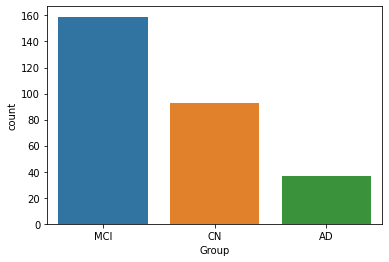

In [38]:
ax = sns.countplot(df['Group'],label="Count")       # M = 212, B = 357
CN, MCI, AD = df.Group.value_counts()
print('Number of Normal people: ',MCI)
print('Number of MCI patient : ',CN)
print('Number of AD patient : ',AD)


# Modeling

In [39]:
#pip install lightgbm

In [40]:

from sklearn.model_selection import train_test_split 

In [41]:
feat=list(df.columns.drop(['Image_Data_ID','Subject','Group']))

In [42]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split( df[feat], 
                                                    df['Group'], 
                                                    test_size=0.33,
                                                    stratify=df['Group'],
                                                    shuffle=True,
                                                    random_state=42)

In [43]:
#The following code is for Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
dtc=DecisionTreeClassifier(max_depth=10)
dtc.fit(X_train,y_train)
accuracy_score(y_test,dtc.predict(X_test))

0.8958333333333334

In [44]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,dtc.predict(X_test))

array([[11,  1,  0],
       [ 1, 27,  3],
       [ 1,  4, 48]])

In [45]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,dtc.predict(X_test)))

              precision    recall  f1-score   support

          AD       0.85      0.92      0.88        12
          CN       0.84      0.87      0.86        31
         MCI       0.94      0.91      0.92        53

    accuracy                           0.90        96
   macro avg       0.88      0.90      0.89        96
weighted avg       0.90      0.90      0.90        96



In [46]:
dtc.classes_ 

array(['AD', 'CN', 'MCI'], dtype=object)

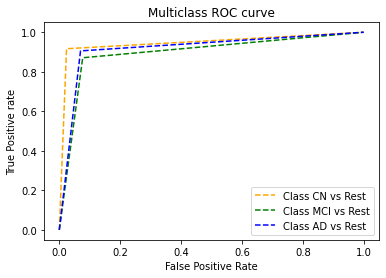

In [47]:
from sklearn.metrics import roc_curve



pred_prob = dtc.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
mmap=pd.Series(np.arange(0,len(dtc.classes_)),index=dtc.classes_ ).to_dict()

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.where(y_test.apply(lambda x: mmap[x])==i,1,0), pred_prob[:,i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class CN vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class MCI vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class AD vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [48]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(dtc, df[feat], df['Group'], scoring = 'accuracy', cv = cv)

print(scores.mean())

0.8962138508371386


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

Text(0, 0.5, 'd_scores')

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

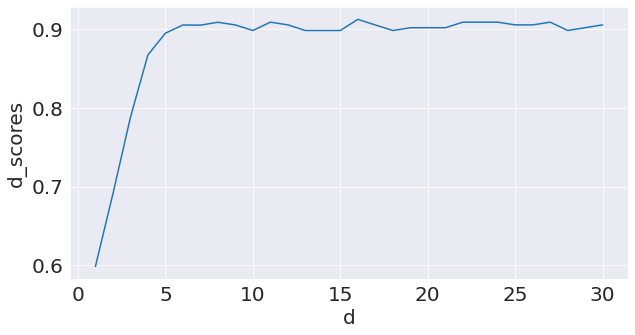

In [49]:
import matplotlib

import matplotlib.pyplot as plt

import seaborn as sns
matplotlib.rc('xtick', labelsize=20) 

matplotlib.rc('ytick', labelsize=20)
%matplotlib inline
d_rad_range = range(1, 31)
d_scores = []
for d in d_rad_range:
  dt = DecisionTreeClassifier(max_depth=d)
  scores = cross_val_score(dt, df[feat], df['Group'], cv=10, scoring='accuracy')
  d_scores.append(scores.mean())
  plt.figure(figsize=(10, 5))

sns.set_style("darkgrid")

plt.plot(d_rad_range, d_scores)

plt.xlabel('d', size=20)

plt.ylabel('d_scores', size=20)

In [50]:
print('Depth of the Decision Tree:', dtc.get_depth())

Depth of the Decision Tree: 7


In [51]:
dtc_predict_train=dtc.predict(X_train)
print('Target on train data', dtc_predict_train)

Target on train data ['MCI' 'AD' 'MCI' 'CN' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI'
 'MCI' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'AD' 'CN'
 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'AD' 'AD'
 'MCI' 'AD' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'AD'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN'
 'AD' 'AD' 'MCI' 'CN' 'AD' 'CN' 'CN' 'CN' 'AD' 'CN' 'AD' 'MCI' 'MCI' 'CN'
 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'AD' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'MCI' 'CN'
 'AD' 'CN' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI'
 'CN' 'AD' 'CN' 'MCI' 'CN' 'MCI' 'AD

In [52]:
dtc_accuracy_train = accuracy_score(y_train,dtc_predict_train)
print('accuracy_score on train dataset : ', dtc_accuracy_train)

accuracy_score on train dataset :  0.9948186528497409


In [53]:
dtc_predict_test=dtc.predict(X_test)
print('Target on test data', dtc_predict_test)

Target on test data ['MCI' 'MCI' 'MCI' 'MCI' 'AD' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'MCI' 'MCI'
 'CN' 'MCI' 'MCI' 'AD' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'AD' 'MCI' 'CN'
 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI'
 'MCI' 'AD' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'AD' 'CN' 'MCI' 'MCI'
 'AD' 'CN' 'MCI' 'CN' 'MCI' 'AD' 'MCI' 'MCI' 'AD' 'CN' 'CN' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'CN'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'AD' 'MCI' 'MCI' 'MCI' 'AD' 'MCI' 'AD'
 'CN' 'AD' 'MCI' 'AD' 'MCI']


In [54]:
dtc_accuracy_test = accuracy_score(y_test,dtc_predict_test)
print('accuracy_score on test dataset : ', dtc_accuracy_test)

accuracy_score on test dataset :  0.8958333333333334


In [100]:
#The following code is for the Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier()
# fit the model with the training data
rfc.fit(X_train,y_train)
# number of trees used
print('Number of Trees used : ', rfc.n_estimators)
# predict the target on the train dataset
rfc_predict_train = rfc.predict(X_train)
print('\nTarget on train data',rfc_predict_train) 

# Accuray Score on train dataset
rfc_accuracy_train = accuracy_score(y_train,rfc_predict_train)
print('\naccuracy_score on train dataset : ', rfc_accuracy_train)

# predict the target on the test dataset
rfc_predict_test = rfc.predict(X_test)
print('\nTarget on test data',rfc_predict_test) 

# Accuracy Score on test dataset
rfc_accuracy_test = accuracy_score(y_test,rfc_predict_test)
print('\naccuracy_score on test dataset : ', rfc_accuracy_test)

Number of Trees used :  100

Target on train data ['MCI' 'AD' 'MCI' 'CN' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI'
 'MCI' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'AD' 'CN'
 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'AD' 'AD'
 'MCI' 'AD' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'AD'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN'
 'AD' 'AD' 'MCI' 'CN' 'AD' 'CN' 'CN' 'CN' 'AD' 'CN' 'AD' 'MCI' 'MCI' 'CN'
 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'AD' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'MCI' 'CN'
 'AD' 'CN' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI'
 'CN' '

In [56]:
from sklearn.metrics import roc_auc_score
i=0
roc_auc_score(np.where(y_test.apply(lambda x: mmap[x])==i,1,0), pred_prob[:,i])

0.9464285714285713

In [101]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,rfc.predict(X_test)))

              precision    recall  f1-score   support

          AD       1.00      0.75      0.86        12
          CN       0.88      0.94      0.91        31
         MCI       0.91      0.92      0.92        53

    accuracy                           0.91        96
   macro avg       0.93      0.87      0.89        96
weighted avg       0.91      0.91      0.91        96



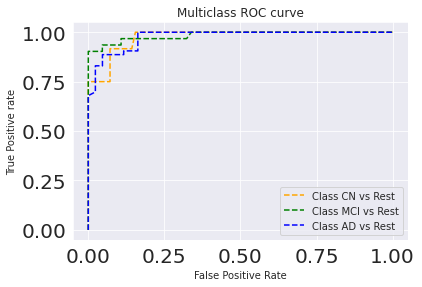

In [57]:
from sklearn.metrics import roc_curve



pred_prob = rfc.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
mmap=pd.Series(np.arange(0,len(rfc.classes_)),index=rfc.classes_ ).to_dict()

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.where(y_test.apply(lambda x: mmap[x])==i,1,0), pred_prob[:,i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class CN vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class MCI vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class AD vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [58]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(rfc, df[feat], df['Group'], scoring = 'accuracy', cv = cv)

print(scores.mean())

0.9134798325722984


In [59]:
#The following code is for Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100,max_depth=5)

# fit the model with the training data
gbc.fit(X_train,y_train)

# predict the target on the train dataset
gbc_predict_train = gbc.predict(X_train)
print('\nTarget on train data',gbc_predict_train) 

# Accuray Score on train dataset
gbc_accuracy_train = accuracy_score(y_train,gbc_predict_train)
print('\naccuracy_score on train dataset : ', gbc_accuracy_train)

# predict the target on the test dataset
gbc_predict_test = gbc.predict(X_test)
print('\nTarget on test data',gbc_predict_test) 

# Accuracy Score on test dataset
gbc_accuracy_test = accuracy_score(y_test,gbc_predict_test)
print('\naccuracy_score on test dataset : ', gbc_accuracy_test)


Target on train data ['MCI' 'AD' 'MCI' 'CN' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI'
 'MCI' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'AD' 'CN'
 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'AD' 'AD'
 'MCI' 'AD' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'AD'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN'
 'AD' 'AD' 'MCI' 'CN' 'AD' 'CN' 'CN' 'CN' 'AD' 'CN' 'AD' 'MCI' 'MCI' 'CN'
 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'AD' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'MCI' 'CN'
 'AD' 'CN' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI'
 'CN' 'AD' 'CN' 'MCI' 'CN' 'MCI' 'A

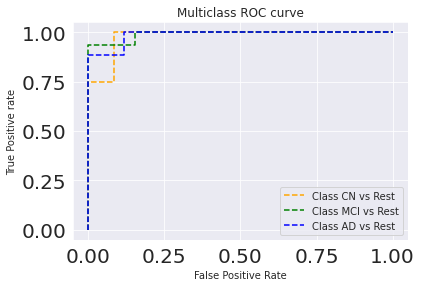

In [96]:
from sklearn.metrics import roc_curve



pred_prob = gbc.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
mmap=pd.Series(np.arange(0,len(gbc.classes_)),index=gbc.classes_ ).to_dict()

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.where(y_test.apply(lambda x: mmap[x])==i,1,0), pred_prob[:,i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class CN vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class MCI vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class AD vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [60]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(gbc, df[feat], df['Group'], scoring = 'accuracy', cv = cv)

print(scores.mean())

0.9065829528158296


In [61]:
# multi-class classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



# fit model
clf = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
clf.fit(X_train, y_train)
# predict the target on the train dataset
clf_predict_train = clf.predict(X_train)
print('\nTarget on train data',clf_predict_train) 

# Accuray Score on train dataset
clf_accuracy_train = accuracy_score(y_train,clf_predict_train)
print('\naccuracy_score on train dataset : ', clf_accuracy_train)

# predict the target on the test dataset
clf_predict_test = clf.predict(X_test)
print('\nTarget on test data',clf_predict_test) 

# Accuracy Score on test dataset
clf_accuracy_test = accuracy_score(y_test,clf_predict_test)
print('\naccuracy_score on test dataset : ', gbc_accuracy_test)



Target on train data ['MCI' 'AD' 'MCI' 'CN' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI'
 'MCI' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'AD' 'CN'
 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'AD' 'AD'
 'MCI' 'AD' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'AD'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN'
 'AD' 'AD' 'MCI' 'CN' 'AD' 'CN' 'CN' 'CN' 'AD' 'CN' 'AD' 'MCI' 'MCI' 'CN'
 'MCI' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'AD' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'MCI' 'CN'
 'AD' 'CN' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI'
 'CN' 'AD' 'CN' 'MCI' 'CN' 'MCI' '

In [98]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

          AD       1.00      0.67      0.80        12
          CN       0.93      0.90      0.92        31
         MCI       0.90      0.98      0.94        53

    accuracy                           0.92        96
   macro avg       0.94      0.85      0.88        96
weighted avg       0.92      0.92      0.91        96



In [62]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(clf, df[feat], df['Group'], scoring = 'accuracy', cv = cv)

print(scores.mean())

0.9411149162861492


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


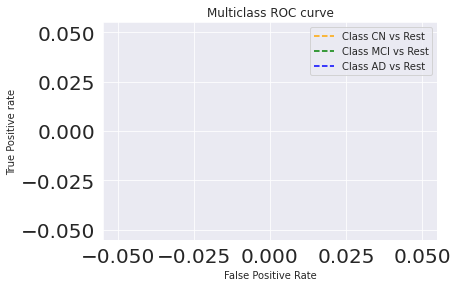

In [63]:

pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class CN vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class MCI vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class AD vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [64]:
#The following code is for XGBOOST 
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()

# fit the model with the training data
xgb.fit(X_train,y_train)


# predict the target on the train dataset
xgb_predict_train = xgb.predict(X_train)
print('\nTarget on train data',xgb_predict_train) 

# Accuray Score on train dataset
xgb_accuracy_train = accuracy_score(y_train,xgb_predict_train)
print('\naccuracy_score on train dataset : ', xgb_accuracy_train)

# predict the target on the test dataset
xgb_predict_test = xgb.predict(X_test)
print('\nTarget on test data',xgb.predict_test) 

# Accuracy Score on test dataset
xgb_accuracy_test = accuracy_score(y_test,xgb_predict_test)
print('\naccuracy_score on test dataset : ', xgb_accuracy_test)


Target on train data ['MCI' 'AD' 'MCI' 'CN' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI'
 'MCI' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'MCI' 'AD' 'CN'
 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'AD' 'AD'
 'MCI' 'AD' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'CN' 'CN' 'MCI' 'AD'
 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI'
 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'MCI' 'MCI' 'AD' 'CN' 'CN'
 'AD' 'AD' 'MCI' 'CN' 'AD' 'CN' 'CN' 'CN' 'AD' 'CN' 'AD' 'MCI' 'MCI' 'CN'
 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI' 'CN' 'AD' 'MCI' 'MCI' 'MCI'
 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'AD' 'AD' 'MCI'
 'CN' 'MCI' 'MCI' 'MCI' 'MCI' 'MCI' 'CN' 'CN' 'MCI' 'MCI' 'AD' 'MCI' 'CN'
 'AD' 'CN' 'CN' 'AD' 'MCI' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'CN' 'MCI' 'MCI'
 'CN' 'AD' 'CN' 'MCI' 'CN' 'MCI' 'A

AttributeError: ignored

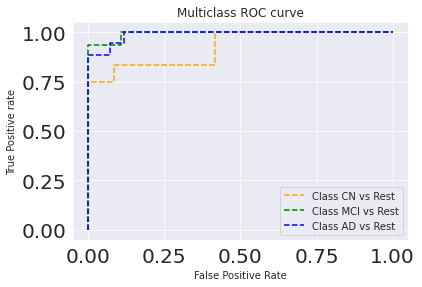

In [94]:
from sklearn.metrics import roc_curve



pred_prob = xgb.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
mmap=pd.Series(np.arange(0,len(xgb.classes_)),index=xgb.classes_ ).to_dict()

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.where(y_test.apply(lambda x: mmap[x])==i,1,0), pred_prob[:,i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class CN vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class MCI vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class AD vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [99]:
from sklearn.metrics import classification_report 
print(classification_report(y_test,xgb.predict(X_test)))

              precision    recall  f1-score   support

          AD       0.82      0.75      0.78        12
          CN       0.97      0.94      0.95        31
         MCI       0.91      0.94      0.93        53

    accuracy                           0.92        96
   macro avg       0.90      0.88      0.89        96
weighted avg       0.92      0.92      0.92        96



In [66]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(xgb, df[feat], df['Group'], scoring = 'accuracy', cv = cv)

print(scores.mean())

0.9238489345509894


In [67]:
X=df[feat]

In [68]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# find best scored 5 features
select_feature = SelectKBest(chi2, k=5).fit(X_train, y_train)
print('Score list:', select_feature.scores_)
print('Feature list:', X_train.columns)


Score list: [1.43474378e+01 3.82809015e+00 4.71016918e-03 9.20589111e-04
 1.40026145e-02 8.45787585e-03 1.40386552e-02 1.41086393e-02
 5.86817984e-01 6.28863896e-01 7.73127422e-01 1.59001762e+00
 9.63165030e-02 3.77884646e-02 9.70903937e+00 8.75778396e+00
 2.78854796e-01 1.90700512e-01 5.59760064e-01 6.00331255e-01
 6.43482466e-01 5.84316264e-01 2.18306087e+00 1.89621834e+00
            nan 7.09535277e-04 7.79879816e-01 2.38526751e-01
 5.38666858e-01 5.52648581e-01 1.75030833e-02 9.99679954e-02
 2.78573796e-02 1.98387729e-01 2.28346626e-01 1.15160922e-01
            nan 1.37354936e-02 8.17343611e-02 1.67775873e-01
 4.50346104e-02 6.92388918e-03 2.57580989e-01 1.82787401e-01
 1.23075788e-02 4.73836967e-02 4.23946383e-01 7.32605713e-01
 1.39490034e-01 3.47292535e-01 2.28585209e-01 1.92468596e-01
 8.06802193e-02 1.11117436e+00 2.69338785e-01 1.54339733e-01
 2.47585344e-01 2.50082948e-02 8.56894333e-01 3.72433134e-01
 1.09410248e+00 8.79747100e-01 1.69282137e-02 1.04247016e-01
 1.06953369e

In [69]:
y=df['Group']

In [70]:
print(select_feature)

SelectKBest(k=5, score_func=<function chi2 at 0x7fc253d3cd40>)


In [71]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
rfc = RandomForestClassifier()      
rfe = RFE(estimator=rfc, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train, y_train)

In [72]:
print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

Chosen best 5 feature by rfe: Index(['GM_lFroPo_', 'CSF_lCau_', 'CSF_rCbeLoCbe1_5_', 'CSF_rMedOrbGy_',
       'CSF_rTemPo_'],
      dtype='object')


In [73]:
from sklearn.feature_selection import RFECV

# The "accuracy" scoring is proportional to the number of correct classifications
rfc = RandomForestClassifier() 
rfecv = RFECV(estimator=rfc, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 5
Best features : Index(['GM_lHip_', 'GM_lFroPo_', 'CSF_lCau_', 'CSF_rCbeLoCbe1_5_',
       'CSF_rMedOrbGy_'],
      dtype='object')


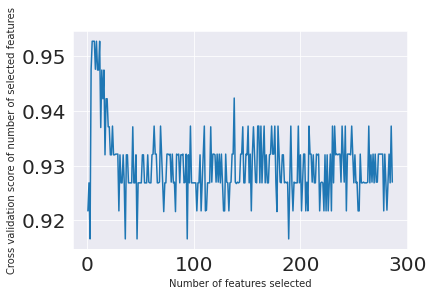

In [74]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [75]:
#LightGBM Model

In [76]:
from lightgbm import LGBMClassifier
lgbc=LGBMClassifier(learning_rate=0.1,
                   n_estimators=50,
                   num_leaves=8)
lgbc.fit(X_train,y_train)
pred=lgbc.predict(X_test)

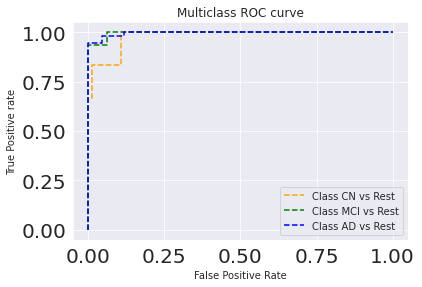

In [95]:
from sklearn.metrics import roc_curve



pred_prob = lgbc.predict_proba(X_test)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
mmap=pd.Series(np.arange(0,len(lgbc.classes_)),index=lgbc.classes_ ).to_dict()

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.where(y_test.apply(lambda x: mmap[x])==i,1,0), pred_prob[:,i])
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class CN vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class MCI vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class AD vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [77]:
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

scores = cross_val_score(lgbc, df[feat], df['Group'], scoring = 'accuracy', cv = cv)

print(scores.mean())

0.934265601217656


In [78]:
from sklearn.metrics import classification_report

#Multi-class classification report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          AD       0.90      0.75      0.82        12
          CN       1.00      0.94      0.97        31
         MCI       0.91      0.98      0.95        53

    accuracy                           0.94        96
   macro avg       0.94      0.89      0.91        96
weighted avg       0.94      0.94      0.94        96



In [79]:
from sklearn.metrics import precision_score,f1_score
sc1=np.round(precision_score(y_test,pred,average='macro'),4)
sc2=np.round(precision_score(y_test,pred,average='micro'),4)
f1=np.round(f1_score(y_test,pred,average='weighted'),4)
print(f'Weighted F1-Score: {np.round(np.mean(f1),4)}, Macro precision score {np.round(np.mean(sc1),4)}, Micro precision score {np.round(np.mean(sc2),4)}\n')

Weighted F1-Score: 0.9364, Macro precision score 0.9374, Micro precision score 0.9375



In [80]:
pip install shap

     |████████████████████████████████| 358kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491614 sha256=134560dadee89af32ad50060c1143fbcbe61de68a239bd5349ab03512ba38157
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


We are getting decent performace from the model. 

# Feature Importance Overall

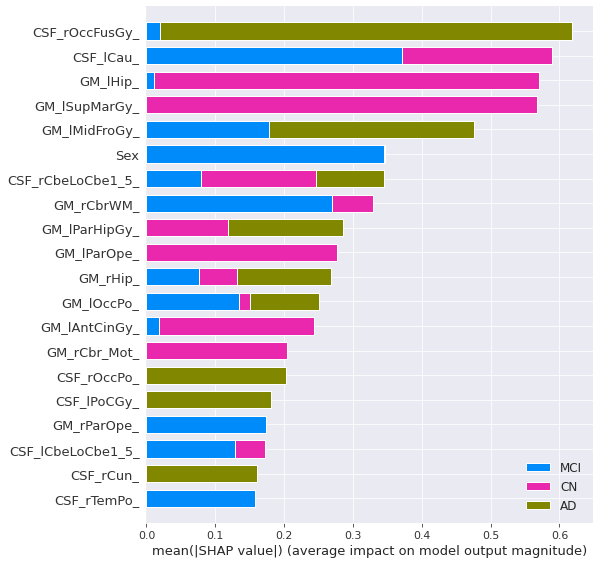

In [81]:
import shap
shap_values = shap.TreeExplainer(lgbc).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar",class_names=list(lgbc.classes_))

# Feature Importnace AD

These are the important features to correctly classify AD Group

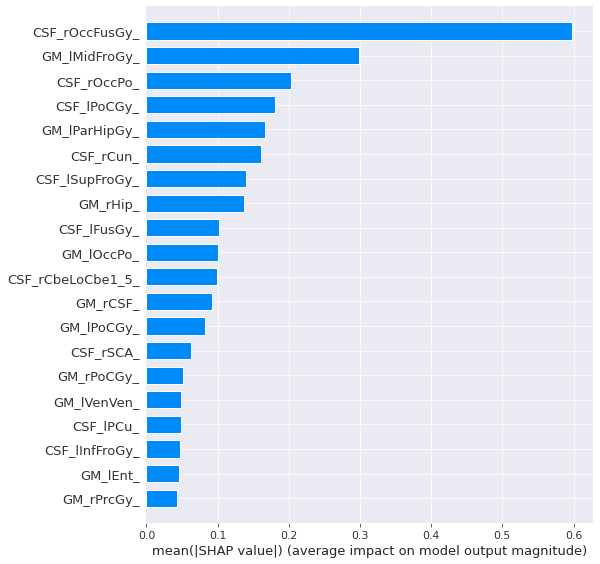

In [82]:
import shap
shap_values = shap.TreeExplainer(lgbc).shap_values(X_test)
shap.summary_plot(shap_values[0], X_test,plot_type="bar",class_names=list(lgbc.classes_)[0])

### Feature Interaction with Group

This Graph Signifies that patient with "CSF rOccFusGy" more than 1.1 are having higher chances to be in AD Group

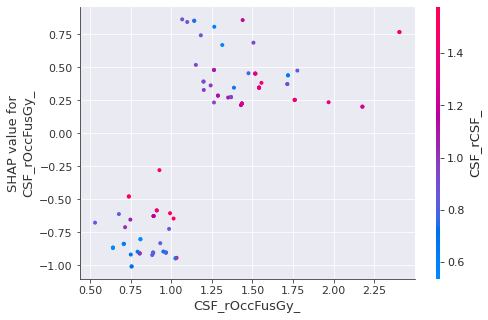

In [83]:
shap.dependence_plot("CSF_rOccFusGy_", shap_values[0], X_test)

This Graph Signifies that patient with "CSF rOccPo" less than 2.2 are having higher chances to be in AD Group

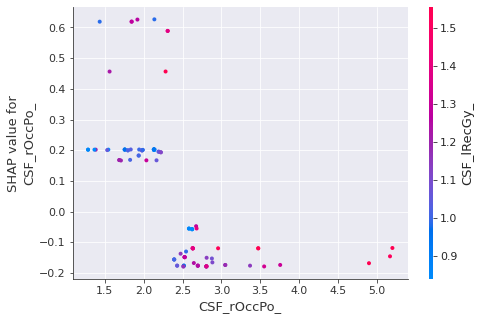

In [84]:
shap.dependence_plot("CSF_rOccPo_", shap_values[0], X_test)

This Graph Signifies that patient with "GM lMidFroGy" less than 16 are having higher chances to be in AD Group

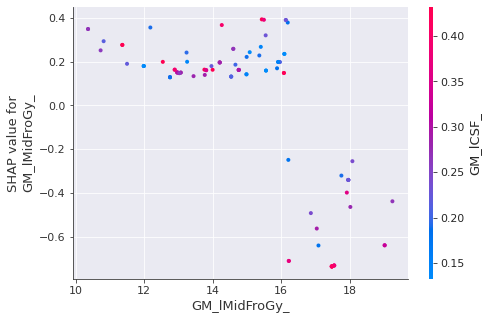

In [85]:
shap.dependence_plot("GM_lMidFroGy_", shap_values[0], X_test)

# Feature Importnace CN

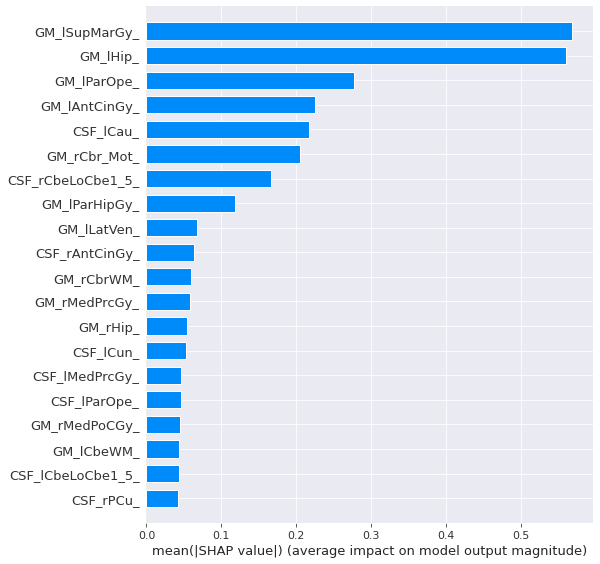

In [86]:
import shap
shap_values = shap.TreeExplainer(lgbc).shap_values(X_test)
shap.summary_plot(shap_values[1], X_test,plot_type="bar",class_names=list(lgbc.classes_)[1])

### Feature Interaction with Group

This Graph Signifies that patient with "GM lHip" more than 2.5 are having higher chances to be in CN Group

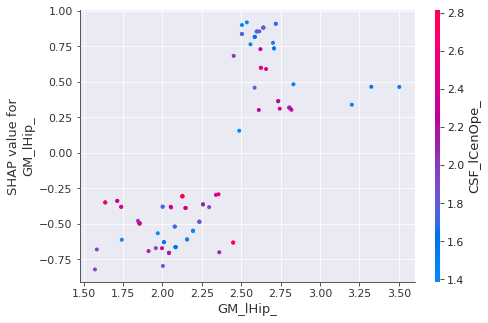

In [87]:
shap.dependence_plot("GM_lHip_", shap_values[1], X_test)

This Graph Signifies that patient with "GM lSupMarGy" more than 6 are having higher chances to be in CN Group

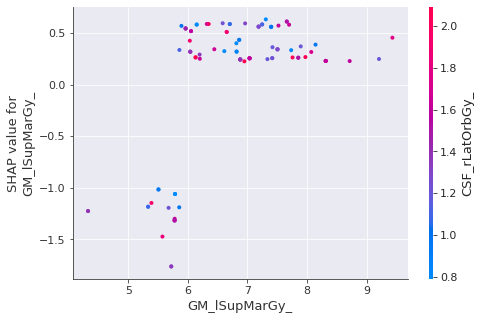

In [88]:
shap.dependence_plot("GM_lSupMarGy_", shap_values[1], X_test)

This Graph Signifies that patient with "GM lAntCinGy" less than 4.4 are having higher chances to be in CN Group

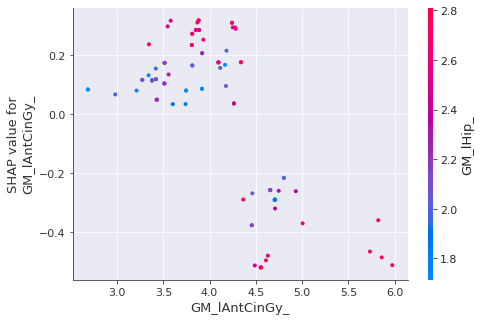

In [89]:
shap.dependence_plot("GM_lAntCinGy_", shap_values[1], X_test)

# Feature Importnace MCI

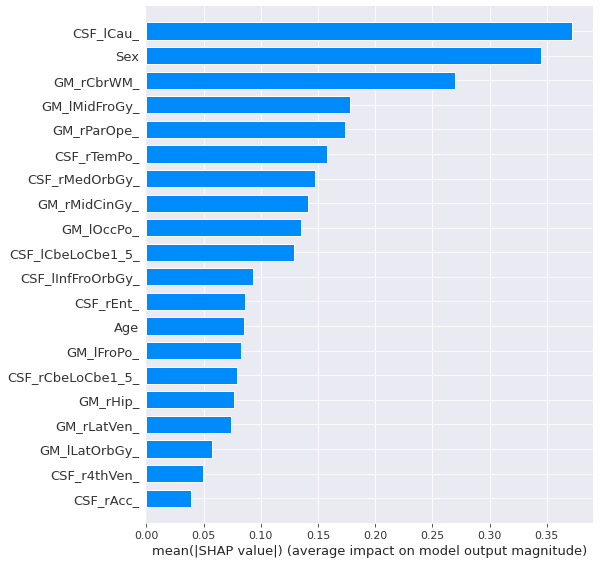

In [90]:
import shap
shap_values = shap.TreeExplainer(lgbc).shap_values(X_test)
shap.summary_plot(shap_values[2], X_test,plot_type="bar",class_names=list(lgbc.classes_)[2])

### Feature Interaction with Group

This Graph Signifies that patient with "Sex" Male are having higher chances to be in MCI Group

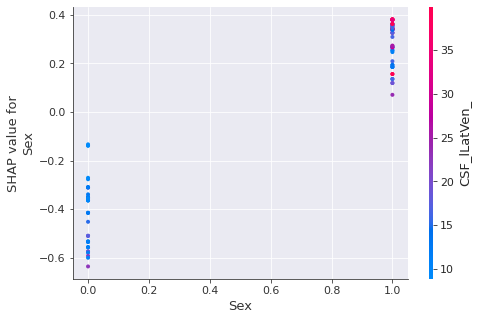

In [91]:
shap.dependence_plot("Sex", shap_values[2], X_test)

This Graph Signifies that patient with "CSF lCau" more than 0.35 are having higher chances to be in MCI Group

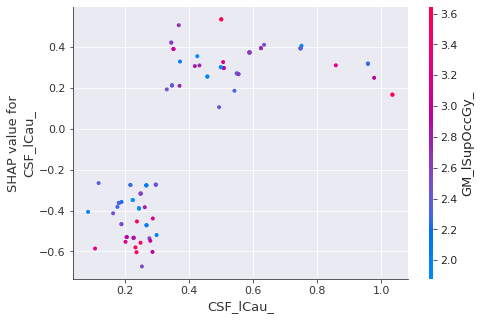

In [92]:
shap.dependence_plot("CSF_lCau_", shap_values[2], X_test)

This Graph Signifies that patient with "GM rCbrWM" less than 6 are having higher chances to be in MCI Group

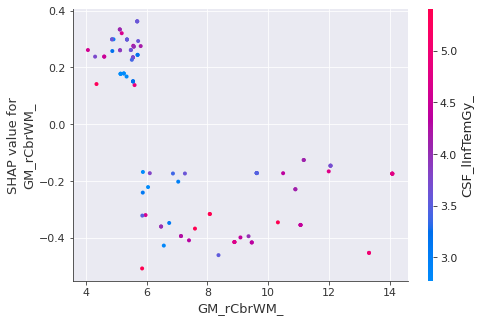

In [93]:
shap.dependence_plot("GM_rCbrWM_", shap_values[2], X_test)